In [7]:
import os
import time
import json
from PIL import Image
import urllib.request
from SPARQLWrapper import SPARQLWrapper, JSON
from urllib.error import HTTPError

endpoint_url = "https://query.wikidata.org/sparql"
img_data = {}

# Requête pour récupérer les infos de l'entité donnée - Q144/Chien par défaut
def query(wd='Q144', limit=5):
    return f"""SELECT ?item ?itemLabel ?pic
                WHERE {{
                  ?item wdt:P31 wd:{wd}.
                  ?item wdt:P18 ?pic.
                  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
                }}
                LIMIT {limit}"""

def get_results(endpoint_url, query):
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    # Boucle de tentative en cas d'erreur 429 Too Many Requests
    for i in range(3):
        try:
            return sparql.query().convert()
        except HTTPError as e:
            if e.response.status_code == 429:
                retry_after = int(e.response.headers.get('Retry-After', '90'))
                print(f"Too Many Requests. Tentative dans {retry_after} secondes.")
                sleep(retry_after)
            else:
                raise e
    
    raise Exception("Nombre maximum de tentatives pour atteindre Wikidata atteint.")

# Pour créer le dossier des images s'il n'existe pas
def createFolder(name='images'):
    if name not in os.listdir():
        os.mkdir(name)
    else:
        print('Dossier '+name+' déjà existant !')

# Pour vérifier si un dossier est vide - évitons de retélécharger des images inutilement.
def isEmpty(name='images'):
    if len(os.listdir(name)) == 0:
        return True
    return False

# Pour ajouter des éléments à la bdd
def addImg(wd, limit):
    results = get_results(endpoint_url, query(wd, limit))
    for result in results['results']['bindings']:
        name_img = result['item']['value'].split("/")[-1] + "-" + wd # nom donné aux images téléchargées "numéro d'image - numéro de catégorie"
        
        #img_data[name_img] = {'image': result['pic']['value']}
        
        img_data[name_img] = {}
        downloadImage(result['pic']['value'], name_img)
        

# Ajoute les images de toutes les entités spécifiées
def addAllImg(wd, limit):
    for w in wd:
        addImg(w, limit)

# Pour télécharger l'image d'un élément de la bdd
def downloadImage(url, name_img='img0'):
    full_path = 'images/' + name_img + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    time.sleep(1)

# Si les images sont déjà téléchargées on initialise le tableau
def initAlreadyDownload(namefolder='images'):
    for image in os.listdir(namefolder):
        #img_data[image.split(".")[0]] = {'image': ""}
        img_data[image.split(".")[0]] = {}

# Pour télécharger toutes les images - limit par query
def downloadAllImages(wd=['Q144'], limit=5):
    createFolder()
    if not isEmpty():
        print('Images déjà téléchargées !')
        initAlreadyDownload()
        return False
    addAllImg(wd, limit)
    return True 



bdd = ['Q144','Q14660','Q23442','Q28803','Q3305213'] #Chien, drapeau, ile, sandwich, peinture,
downloadAllImages(wd=bdd,limit=25)
print(img_data)


{'Q5270723-Q144': {}, 'Q5288274-Q144': {}, 'Q5375926-Q144': {}, 'Q5515388-Q144': {}, 'Q5619202-Q144': {}, 'Q5686986-Q144': {}, 'Q5859102-Q144': {}, 'Q5902587-Q144': {}, 'Q5905086-Q144': {}, 'Q5970618-Q144': {}, 'Q6072863-Q144': {}, 'Q6104495-Q144': {}, 'Q6155312-Q144': {}, 'Q6188949-Q144': {}, 'Q6304312-Q144': {}, 'Q6343845-Q144': {}, 'Q6417173-Q144': {}, 'Q6469343-Q144': {}, 'Q6537509-Q144': {}, 'Q6819212-Q144': {}, 'Q6962578-Q144': {}, 'Q7033137-Q144': {}, 'Q7084299-Q144': {}, 'Q7123658-Q144': {}, 'Q7126106-Q144': {}, 'Q19010-Q14660': {}, 'Q19374-Q14660': {}, 'Q72298-Q14660': {}, 'Q121688-Q14660': {}, 'Q122482-Q14660': {}, 'Q145637-Q14660': {}, 'Q148002-Q14660': {}, 'Q163008-Q14660': {}, 'Q168935-Q14660': {}, 'Q172446-Q14660': {}, 'Q173201-Q14660': {}, 'Q369833-Q14660': {}, 'Q371718-Q14660': {}, 'Q404150-Q14660': {}, 'Q435309-Q14660': {}, 'Q435723-Q14660': {}, 'Q437841-Q14660': {}, 'Q458651-Q14660': {}, 'Q459788-Q14660': {}, 'Q495495-Q14660': {}, 'Q497887-Q14660': {}, 'Q498887-Q14660

In [8]:
import os
import json
from PIL import Image
import urllib.request
from SPARQLWrapper import SPARQLWrapper, JSON
from urllib.error import HTTPError
import time
import shutil
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import webcolors

#Supprimer une image du dossier 
def removeImage(name):
    image_path = "images/" + name
    if os.path.isfile(image_path):
        os.remove(image_path)
        print(f"L'image {name} a été supprimée.")
    else:
        print(f"Impossible de trouver le fichier {image_path}")

#Obtenir les metas d'une image
def getMetaImg(name, imgfile):
    #clés Exif
    DATE_KEY = 36867
    MODEL_KEY = 272
    
    img_data[name].update({
        #'size': [getSizeImg(imgfile.size), imgfile.size],
        'size': getSizeImg(imgfile.size),
        'orientation': getOrientationImg(imgfile.size),
        'format': imgfile.format,
    })
    
    getColorsImg(name, imgfile)
    
    exif_data = imgfile._getexif()
    if exif_data is not None:
        if DATE_KEY in exif_data:
            img_data[name]['date'] = exif_data[DATE_KEY]
        if MODEL_KEY in exif_data:
            img_data[name]['model'] = exif_data[MODEL_KEY]

def getOrientationImg(size): #(largeur,hauteur)
    width,height = size
    return "landscape" if width > height else "portrait" if height > width else "squared"
    
def getSizeImg(size): #(largeur,hauteur)
    width,height = size
    return "large" if width*height>1920*1080 else "small" if width*height<640*480 else "medium"
    
def getColorsImg(name, imgfile, cluster_nbr=2, n_init=1):
    
    img_data[name]['colors'] = []
    
    # Redimensionner l'image pour accélérer le traitement
    imgfile = imgfile.resize((int(imgfile.size[0]/2), int(imgfile.size[1]/2)))

    # Convertir l'image en un tableau numpy
    img_array = np.array(imgfile)
    
    try:
        img_vector = img_array.reshape(-1, 3)

        clusters = MiniBatchKMeans(n_clusters=cluster_nbr, n_init=n_init, random_state=69).fit(img_vector) #Random state pour garder la meme seed ppour toutes les images

        for i, center in enumerate(clusters.cluster_centers_):
            rgb = tuple(map(int, center))
        

            img_data[name]['colors'].append(rgb)
            
    except Exception as e:
        print('Pas de couleur : {}'.format(e))
        #img_data[name]['colors'] = [-1]

def RGBtoName(rgb):
    try:
        # Attempt to find the exact color name
        color_name = webcolors.rgb_to_name(rgb)
    except ValueError:
        # If exact name not found, find the closest color name
        min_difference = None
        closest_color = None
        for name, hex_value in webcolors.CSS3_NAMES_TO_HEX.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(hex_value)
            difference = sum([(r_c - rgb[0]) ** 2, (g_c - rgb[1]) ** 2, (b_c - rgb[2]) ** 2])
            if min_difference is None or difference < min_difference:
                min_difference = difference
                closest_color = name
        color_name = closest_color
    return color_name


def openImgGetMeta(name): #name = 'img.jpg'
    try:
        with Image.open("images/"+name) as imgfile:
            #print(imgfile.size, imgfile.format)
            name = name.split(".")[0]
            getMetaImg(name, imgfile)

        imgfile.close()
        return True
    except FileNotFoundError as e:
        print('Impossible de trouver le fichier {}: {}'.format("images/"+name, e))
        return False
    except Exception as e:
        print('Erreur lors de l\'ouverture de l\'image {}: {}'.format("images/"+name, e))
        removeImage(name)
        return False
        
#Obtenir les metas de toutes nos images    
def openGetMetaAllImg(namefolder='images'):
    for image in os.listdir(namefolder):
        # Ignore .ipynb_checkpoints and non-image files
        if image.endswith((".png", ".jpg", ".jpeg", ".gif", ".bmp")):
            openImgGetMeta(image)


openGetMetaAllImg()


Erreur lors de l'ouverture de l'image images/Q111589124-Q28803: _getexif
Impossible de trouver le fichier images/Q111589124-Q28803
Erreur lors de l'ouverture de l'image images/Q121688-Q14660.jpg: cannot identify image file 'images/Q121688-Q14660.jpg'
L'image Q121688-Q14660.jpg a été supprimée.
Erreur lors de l'ouverture de l'image images/Q122482-Q14660.jpg: cannot identify image file 'images/Q122482-Q14660.jpg'
L'image Q122482-Q14660.jpg a été supprimée.
Erreur lors de l'ouverture de l'image images/Q148002-Q14660.jpg: cannot identify image file 'images/Q148002-Q14660.jpg'
L'image Q148002-Q14660.jpg a été supprimée.
Erreur lors de l'ouverture de l'image images/Q163008-Q14660.jpg: cannot identify image file 'images/Q163008-Q14660.jpg'
L'image Q163008-Q14660.jpg a été supprimée.
Erreur lors de l'ouverture de l'image images/Q168935-Q14660.jpg: cannot identify image file 'images/Q168935-Q14660.jpg'
L'image Q168935-Q14660.jpg a été supprimée.
Erreur lors de l'ouverture de l'image images/Q172

In [9]:
import requests
import json

#Enregistre les metadonnées des images dans un JSON
def exportToJSON(data,name='img_data.json'):
    with open(name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print("done")
#exportToJSON(data=img_data)

def openJSON(file="img_data.json"):
    # Ouvrir le fichier JSON en mode lecture (fermé automatiquement)
    with open(file, 'r') as f:
        data = json.load(f)
    return data
# Requête API à Wikidata pour récupérer les catégories de l'image
def wikidataAPI(_id,lang):
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={_id}&props=labels|claims&languages={lang}&format=json"
    response = requests.get(url)
    return json.loads(response.text)


def findTagsImg(_id, lang='en'): #"Q7704028-Q144"
    
    image_id, cat_id = _id.split("-")
    
    # Requête API à Wikidata pour récupérer les catégories de l'image
    
    img_data = wikidataAPI(image_id,lang)
    cat_data = wikidataAPI(cat_id,lang)
    
    # Extraire le libellé de la catégorie dans la langue souhaitée
    main_tag = cat_data.get('entities', {}).get(cat_id, {}).get('labels', {}).get(lang, {}).get('value', '')
    
    # Trouver les catégories dans la réponse de la requête API sur l'image
    #claims = img_data.get("entities", {}).get(image_id, {}).get("claims", {})
    #print([x['mainsnak']['datavalue']['value'] for prop in ["P910", "P373"] for x in claims.get(prop, [])])
    #categories = formatCategory([x['mainsnak']['datavalue']['value'] for prop in ["P910", "P373"] for x in claims.get(prop, [])])
            
    #if main_tag not in categories:
        #categories.append(main_tag)
        
    categories = [main_tag]
    
    return categories


def formatCategory(categories):
    categories_ = []
    
    removeCar = ['(', ')']
    splitCar = [',', ' ']
    
    for category in categories:
        if isinstance(category, str):
            for car in removeCar:
                category = category.replace(car, '')
            for car in splitCar:
                parts = category.split(car)
                if len(parts) > 1:
                    categories_.extend(parts[1:])
                    category = parts[0]
            categories_.append(category.lower())
    
    return categories_


def addTagsJSON(image_id = "Q7704028", categories=[]):
    data = openJSON(file="img_data.json")
    data[image_id]['tags'] = categories


def addAllTagsJSON():
    for _id in data:
        data[_id]['tags'] = findTagsImg(_id)
    return data

data = openJSON(file="img_data.json")
data = addAllTagsJSON()
exportToJSON(data)


done


In [13]:
class User:
    def __init__(self, favorite_pictures=None):
        self._favorite_colors = []
        self._favorite_orientations = []
        self._favorite_sizes = []
        self._favorite_tags = []
        self._favorite_pictures = [] if favorite_pictures is None else favorite_pictures

    def __str__(self):
        return f"User with favorite color {self._favorite_colors}, orientation {self._favorite_orientations}, size {self._favorite_sizes}, tags {self._favorite_tags} and favorite pictures {self._favorite_pictures}"

    def add_favorite_picture(self, picture):
        self._favorite_pictures.append(picture)
        img_data = data[picture.split(".")[0]]
        self._favorite_colors.append(img_data["colors"])
        self._favorite_orientations.append(img_data["orientation"])
        self._favorite_tags.append(img_data["tags"])
        self._favorite_sizes.append(img_data["size"])

    def remove_favorite_picture(self, picture):
        picture_index = self._favorite_pictures.index(picture)
        self._favorite_pictures.pop(picture_index)
        self._favorite_colors.pop(picture_index)
        self._favorite_orientations.pop(picture_index)
        self._favorite_tags.pop(picture_index)
        self._favorite_sizes.pop(picture_index)

    def get_favorite_pictures(self):
        return self._favorite_pictures

    def get_favorite_tags(self):
        return self._favorite_tags

    def get_favorite_orientations(self):
        return self._favorite_orientations

    def get_favorite_colors(self):
        return self._favorite_colors

    def get_favorite_sizes(self):
        return self._favorite_sizes


In [70]:
import random
# Créer une liste d'utilisateurs vides
number_users = 15
users = [None] * number_users

# Créer un utilisateur avec une liste aléatoire de photos préférées
for i in range(number_users):

    number_pictures_liked = random.randint(10, 30)

    max_pictures_liked = min(len(dataFrame), 30)
    if max_pictures_liked == 0:
        print("Il n'y a pas d'images dans le répertoire.")
    else:
        number_pictures_liked = random.randint(1, max_pictures_liked)

    user = User(favorite_pictures=random.sample(list(dataFrame.index), k=number_pictures_liked))
    users[i] = user
    print(user.get_favorite_pictures())


['Q1760470-Q28803', 'Q5736147-Q28803', 'Q5970618-Q144', 'Q630121-Q3305213', 'Q613390-Q3305213', 'Q437841-Q14660', 'Q124351850-Q28803', 'Q85774221-Q28803']
['Q53844640-Q28803', 'Q148002-Q14660', 'Q6059-Q23442', 'Q9704-Q23442', 'Q9679-Q23442', 'Q5288274-Q144', 'Q614047-Q3305213', 'Q6155312-Q144', 'Q6072863-Q144', 'Q636001-Q3305213', 'Q6188949-Q144', 'Q9729-Q23442', 'Q435723-Q14660', 'Q5993-Q23442', 'Q3237-Q23442', 'Q609986-Q3305213', 'Q5905086-Q144', 'Q5619202-Q144', 'Q6819212-Q144', 'Q5613356-Q28803', 'Q642023-Q3305213', 'Q7084299-Q144', 'Q5686986-Q144', 'Q273-Q23442', 'Q6343845-Q144', 'Q435309-Q14660', 'Q642198-Q3305213', 'Q371718-Q14660', 'Q644734-Q3305213', 'Q124351850-Q28803']
['Q642023-Q3305213', 'Q173201-Q14660']
['Q5515388-Q144', 'Q6304312-Q144', 'Q644106-Q3305213', 'Q4648-Q23442', 'Q3255-Q23442', 'Q9704-Q23442', 'Q609986-Q3305213', 'Q636001-Q3305213', 'Q273-Q23442', 'Q5993-Q23442', 'Q7126106-Q144', 'Q437841-Q14660', 'Q497887-Q14660', 'Q1760470-Q28803', 'Q6417173-Q144', 'Q6188949

In [71]:
import pandas as pd 
dataFrame = pd.read_json('img_data.json').T
dataFrame

,size,orientation,format,colors,tags,date,model
Q5270723-Q144,small,landscape,JPEG,"[[90, 90, 90], [175, 175, 175]]",[dog],NaN,NaN
Q5288274-Q144,large,landscape,JPEG,"[[40, 38, 26], [215, 214, 212]]",[dog],2018:07:21 12:02:43,LGM-K121L                      
Q5375926-Q144,large,portrait,JPEG,"[[43, 40, 41], [157, 145, 134]]",[dog],NaN,NaN
Q5515388-Q144,large,landscape,JPEG,"[[194, 187, 177], [122, 111, 107]]",[dog],2007:11:02 15:17:17,KODAK CX7330 ZOOM DIGITAL CAMERA
Q5619202-Q144,small,portrait,JPEG,"[[177, 177, 177], [72, 72, 72]]",[dog],NaN,NaN
...,...,...,...,...,...,...,...
Q641666-Q3305213,large,portrait,JPEG,"[[40, 33, 27], [181, 166, 146]]",[painting],NaN,NaN
Q642023-Q3305213,medium,landscape,JPEG,"[[87, 71, 51], [183, 164, 138]]",[painting],NaN,NaN
Q642198-Q3305213,large,portrait,JPEG,"[[180, 160, 124], [77, 54, 28]]",[painting],2010:04:07 01:32:24,NaN
Q644106-Q3305213,large,portrait,JPEG,"[[119, 107, 97], [39, 28, 20]]",[painting],NaN,NaN


In [72]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
dataFrame = pd.read_json('img_data.json').T

# Convertir la taille en une valeur numérique
dataFrame['size'] = dataFrame['size'].map({'small': 0, 'medium': 0.5, 'large':1})

# Convertir l'orientation en une valeur numérique
dataFrame['orientation'] = dataFrame['orientation'].map({'landscape': 0, 'portrait': 1, 'squared':0.5})

# Convertir l'orientation en une valeur numérique
dataFrame['format'] = dataFrame['format'].map({'JPEG': 0, 'MPO': 0.5, 'PNG':1})

# Vérifier si la valeur de la colonne 'colors' est une liste
dataFrame['colors'] = dataFrame['colors'].apply(lambda x: [[0,0,0], [0,0,0]] if isinstance(x, float) else x)

# ajouter les 6 colonnes de couleurs séparées
dataFrame["r1"] = [couleur[0][0]/255 if len(couleur) > 0 and len(couleur[0]) > 0 else 0 for couleur in dataFrame["colors"]]
dataFrame["g1"] = [couleur[0][1]/255 if len(couleur) > 0 and len(couleur[0]) > 1 else 0 for couleur in dataFrame["colors"]]
dataFrame["b1"] = [couleur[0][2]/255 if len(couleur) > 0 and len(couleur[0]) > 2 else 0 for couleur in dataFrame["colors"]]
dataFrame["r2"] = [couleur[1][0]/255 if len(couleur) > 1 and len(couleur[1]) > 0 else 0 for couleur in dataFrame["colors"]]
dataFrame["g2"] = [couleur[1][1]/255 if len(couleur) > 1 and len(couleur[1]) > 1 else 0 for couleur in dataFrame["colors"]]
dataFrame["b2"] = [couleur[1][2]/255 if len(couleur) > 1 and len(couleur[1]) > 2 else 0 for couleur in dataFrame["colors"]]

dataFrame = dataFrame.drop(columns=['colors'])

dataFrame = dataFrame.drop(columns=['date','model'])

# Création de l'instance de MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Binarisation des tags
tags_binarized = mlb.fit_transform(dataFrame['tags'])

# Création d'un DataFrame à partir des tags binarisés
tags_df = pd.DataFrame(tags_binarized, columns=mlb.classes_, index= dataFrame['tags'].index)

# Concaténation du DataFrame initial et du DataFrame des tags binarisés
dataFrame = pd.concat([dataFrame, tags_df], axis=1)

# Suppression de la colonne 'tags'
dataFrame.drop('tags', axis=1, inplace=True)

#Ajout des likes:
dataFrame['liked'] = np.zeros(len(dataFrame['r1'].index))

for img in user._favorite_pictures:
    dataFrame.at[img.split('.')[0], 'liked'] = 1

dataFrame


,size,orientation,format,r1,g1,b1,r2,g2,b2,dog,flag,island,painting,sandwich,liked
Q5270723-Q144,0.0,0.0,0.0,0.352941,0.352941,0.352941,0.686275,0.686275,0.686275,1,0,0,0,0,0.0
Q5288274-Q144,1.0,0.0,0.0,0.156863,0.149020,0.101961,0.843137,0.839216,0.831373,1,0,0,0,0,0.0
Q5375926-Q144,1.0,1.0,0.0,0.168627,0.156863,0.160784,0.615686,0.568627,0.525490,1,0,0,0,0,0.0
Q5515388-Q144,1.0,0.0,0.0,0.760784,0.733333,0.694118,0.478431,0.435294,0.419608,1,0,0,0,0,0.0
Q5619202-Q144,0.0,1.0,0.0,0.694118,0.694118,0.694118,0.282353,0.282353,0.282353,1,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q641666-Q3305213,1.0,1.0,0.0,0.156863,0.129412,0.105882,0.709804,0.650980,0.572549,0,0,0,1,0,0.0
Q642023-Q3305213,0.5,0.0,0.0,0.341176,0.278431,0.200000,0.717647,0.643137,0.541176,0,0,0,1,0,0.0
Q642198-Q3305213,1.0,1.0,0.0,0.705882,0.627451,0.486275,0.301961,0.211765,0.109804,0,0,0,1,0,0.0
Q644106-Q3305213,1.0,1.0,0.0,0.466667,0.419608,0.380392,0.152941,0.109804,0.078431,0,0,0,1,0,0.0


In [73]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Charger le dataframe à partir du fichier JSON
dataFrame = pd.read_json('img_data.json').T

# Supprimer les colonnes inutiles
dataFrame = dataFrame.drop(columns=['date', 'model'])

# Convertir les colonnes 'size', 'orientation' et 'format' en colonnes numériques
le = LabelEncoder()
dataFrame['size'] = le.fit_transform(dataFrame['size'])
dataFrame['orientation'] = le.fit_transform(dataFrame['orientation'])
dataFrame['format'] = le.fit_transform(dataFrame['format'])

# Extraire les couleurs dominantes sous forme de chaînes de caractères hexadécimales
def extraire_couleurs(couleurs):
    if not isinstance(couleurs, list) or len(couleurs) != 2:
        return ['000000', '000000']
    couleur_1 = tuple(round(255 * c) for c in couleurs[0])
    couleur_2 = tuple(round(255 * c) for c in couleurs[1])
    return ['{:02x}{:02x}{:02x}'.format(*couleur_1), '{:02x}{:02x}{:02x}'.format(*couleur_2)]

dataFrame[['couleur_1', 'couleur_2']] = dataFrame['colors'].apply(extraire_couleurs).apply(pd.Series)

# Convertir la colonne 'tags' en colonne numérique
dataFrame['tag'] = dataFrame['tags'].apply(lambda x: x[0] if len(x) > 0 else None)
dataFrame['tag'] = le.fit_transform(dataFrame['tag'])

# Supprimer les colonnes inutiles
dataFrame = dataFrame.drop(columns=['colors', 'tags'])
dataFrame.head()

,size,orientation,format,couleur_1,couleur_2,tag
Q5270723-Q144,2,0,0,59a659a659a6,ae51ae51ae51,0
Q5288274-Q144,0,0,0,27d825da19e6,d629d52ad32c,0
Q5375926-Q144,0,1,0,2ad527d828d7,9c63906f857a,0
Q5515388-Q144,0,0,0,c13eba45b04f,79866e916a95,0
Q5619202-Q144,2,1,0,b04fb04fb04f,47b847b847b8,0


In [76]:
#liked_photos = resultframe.query('liked == 1')
#liked_photos.head(15)
#Ajout des likes:
dataFrame['liked'] = np.array('NL')
for img in user._favorite_pictures:
    dataFrame.at[img.split('.')[0], 'liked'] = 'liked'


resultframe = pd.DataFrame(np.full(len(dataFrame),"not liked"), columns=['liked'], index= dataFrame['size'].index)
for img in user._favorite_pictures:
    resultframe.at[img.split('.')[0], 'liked'] = 'liked'

le7 = LabelEncoder()

print(resultframe)
resultframe['liked'] = le7.fit_transform(resultframe['liked'])



resultframe

                      liked
Q6304312-Q144     not liked
Q19010-Q14660     not liked
Q19374-Q14660     not liked
Q72298-Q14660     not liked
Q121688-Q14660    not liked
Q122482-Q14660    not liked
Q148002-Q14660    not liked
Q163008-Q14660    not liked
Q168935-Q14660    not liked
Q172446-Q14660        liked
Q173201-Q14660    not liked
Q369833-Q14660    not liked
Q371718-Q14660    not liked
Q404150-Q14660    not liked
Q435309-Q14660    not liked
Q435723-Q14660    not liked
Q437841-Q14660    not liked
Q458651-Q14660    not liked
Q459788-Q14660        liked
Q495495-Q14660    not liked
Q497887-Q14660    not liked
Q498887-Q14660    not liked
Q3812-Q23442      not liked
Q636537-Q3305213  not liked
Q644734-Q3305213      liked
Q6072863-Q144         liked
Q1408045-Q28803       liked
Q3492-Q23442          liked
Q613928-Q3305213      liked
Q7564-Q23442          liked


,liked
Q6304312-Q144,1
Q19010-Q14660,1
Q19374-Q14660,1
Q72298-Q14660,1
Q121688-Q14660,1
Q122482-Q14660,1
Q148002-Q14660,1
Q163008-Q14660,1
Q168935-Q14660,1
Q172446-Q14660,0


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Identifier les colonnes qui contiennent des valeurs de type chaîne de caractères
string_cols = dataFrame.select_dtypes(include=['object']).columns

# Convertir les colonnes en un type numérique approprié
for col in string_cols:
    dataFrame[col] = pd.to_numeric(dataFrame[col], errors='coerce')

# Supprimer les lignes contenant des valeurs manquantes
dataFrame.dropna(inplace=True)

print(dataFrame.shape)
print(resultframe.shape)

# Séparation en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(dataFrame, resultframe, test_size=0.2, random_state=69)

# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Entraînement du modèle
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Évaluation du modèle
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

# Affichage de l'arbre de décision
dot_data = tree.export_graphviz(
    dtc, 
    out_file=None,
    filled=True, 
    rounded=True,
    class_names=le7.inverse_transform(resultframe.liked.unique()),
    feature_names=dataFrame.columns,
    proportion=True,
    impurity=False,
    precision=2,
    node_ids=True
) 

graph = graphviz.Source(dot_data) 
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

import io

img = Image.open(io.BytesIO(pydot_graph.create_png()))
display(img)

# Affichage de l'importance des variables
importances = dtc.feature_importances_
indices = np.argsort(importances)[::-1]
print("Importance des variables :")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, dataFrame.columns[indices[f]], importances[indices[f]]))
    
    
print(y_pred)

(0, 7)
(30, 1)


ValueError: Found input variables with inconsistent numbers of samples: [0, 30]

{'': 78, '2018:': 4, '2007:': 5, '2017:': 1, '2011:': 1, '2013:': 3, '2008:': 2, '2004:': 2, '2016:': 1, '2002:': 1, '2009:': 1, '2021:': 3, '2010:': 5, '2015:': 1, '2014:': 2, '2019:': 1, '0000:': 1}


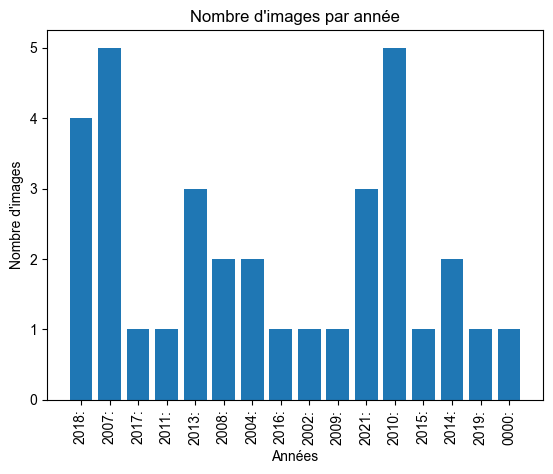

In [93]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
nb_images_year = {}

for image in data:
    date = data[image].get('date', '')[0:5] #Recupere la date de l'image
    nb_images_year[date] = nb_images_year.get(date,0) +1
    
print(nb_images_year)

#Si on veut retirer les images sans date:
nb_images_year.pop('')

noms = list(nb_images_year.keys())
valeurs = list(nb_images_year.values())

plt.bar(noms, valeurs)
plt.title("Nombre d'images par année")
plt.xlabel("Années")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90)
plt.show()

{'small': 17, 'large': 45, 'medium': 28, '': 22}
{'landscape': 56, 'portrait': 32, 'squared': 2, '': 22}
{'': 81, 'LGM-K121L\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00': 1, 'KODAK CX7330 ZOOM DIGITAL CAMERA': 1, 'Canon EOS 550D': 2, 'SM-G960F': 1, 'iPhone 5': 1, 'Canon EOS 7D': 1, 'DMC-TZ3': 1, 'DiMAGE Z1': 1, 'Digimax V4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00': 1, 'C2000Z': 1, 'DSC-V1': 1, 'NIKON D5': 1, 'NIKON D300S': 1, 'COOLPIX P6000\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00': 1, 'NIKON D5100': 1, 'Canon PowerShot A460': 1, 'FC3411': 1, 'CPH1723\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00': 1, 'Canon EOS 650D': 1, 'iPhone 4S': 1, 'iPhone XS': 1, 'NIKON D90': 1, 'C765UZ': 1, 'Canon PowerShot SD20': 1, 'iPhone 8 Plus': 1, 'DSC-T100': 1, 'E5700': 1, 'Canon DIGITAL IXUS 100 IS': 1, 'GT-I9100': 1, 'Hasselblad CF528-39

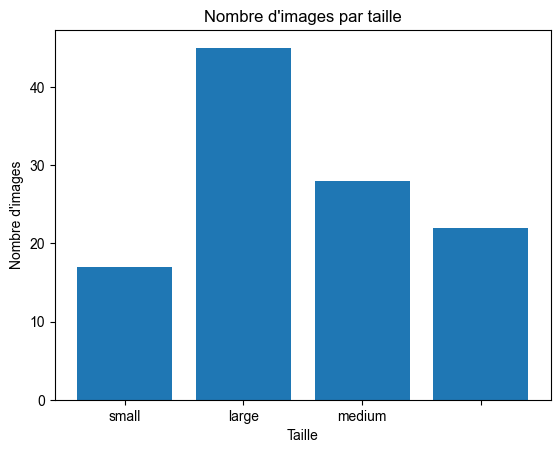

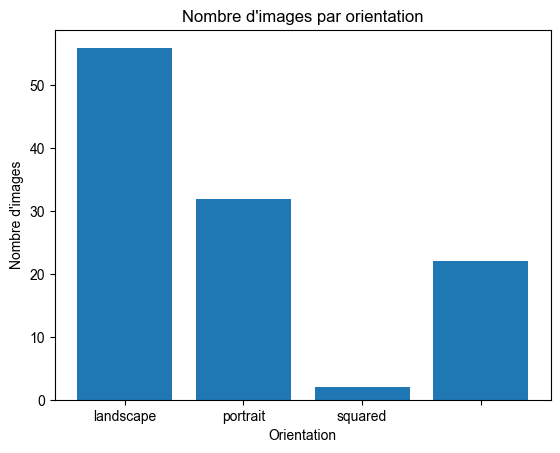

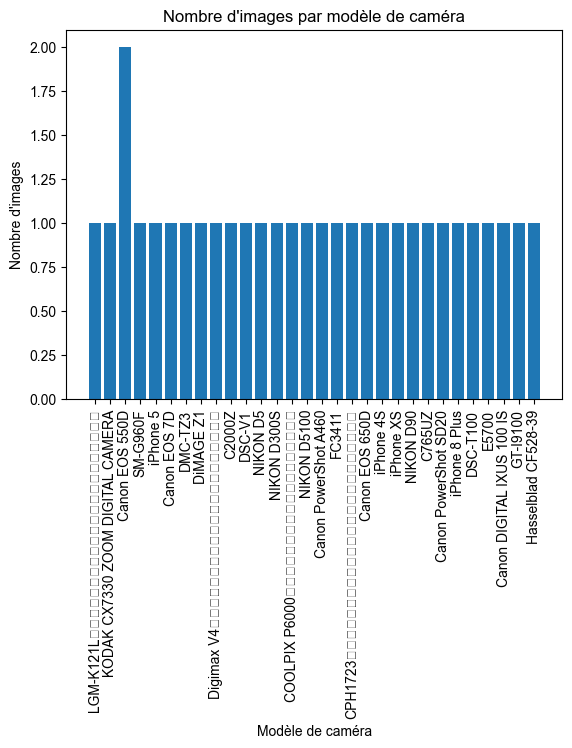

In [92]:
nb_images_size = {}
nb_images_orientation = {}
nb_images_camera = {}

plt.rcParams['font.family'] = 'Arial'

for image in data :
   size = data[image].get('size','')
   nb_images_size[size] = nb_images_size.get(size,0) +1
  
   orientation = data[image].get('orientation','')
   nb_images_orientation[orientation] = nb_images_orientation.get(orientation,0) +1
  
   camera = data[image].get('model','')
   nb_images_camera[camera] = nb_images_camera.get(camera,0) +1
  
print(nb_images_size)
print(nb_images_orientation)
print(nb_images_camera)

nb_images_camera.pop('')

entity1 = list(nb_images_size.keys())
val1 = list(nb_images_size.values())
plt.bar(entity1, val1)
plt.title("Nombre d'images par taille")
plt.xlabel("Taille")
plt.ylabel("Nombre d'images")
plt.show()


entity2 = list(nb_images_orientation.keys())
val2 = list(nb_images_orientation.values())
plt.bar(entity2, val2)
plt.title("Nombre d'images par orientation")
plt.xlabel("Orientation")
plt.ylabel("Nombre d'images")
plt.show()


entity3 = list(nb_images_camera.keys())
val3 = list(nb_images_camera.values())
plt.bar(entity3, val3)
plt.title("Nombre d'images par modèle de caméra")
plt.xlabel("Modèle de caméra")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90) # Fait pivoter les étiquettes x de 45 degrés pour améliorer la lisibilité
plt.show()

{'LGM-K121L\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00': ['LGM-K121L\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'], 'KODAK': ['KODAK CX7330 ZOOM DIGITAL CAMERA'], 'Canon': ['Canon EOS 550D', 'Canon EOS 7D', 'Canon PowerShot A460', 'Canon EOS 650D', 'Canon PowerShot SD20', 'Canon DIGITAL IXUS 100 IS'], 'SM-G960F': ['SM-G960F'], 'iPhone': ['iPhone 5', 'iPhone 4S', 'iPhone XS', 'iPhone 8 Plus'], 'DMC-TZ3': ['DMC-TZ3'], 'DiMAGE': ['DiMAGE Z1'], 'Digimax': ['Digimax V4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'], 'C2000Z': ['C2000Z'], 'DSC-V1': ['DSC-V1'], 'NIKON': ['NIKON D5', 'NIKON D300S', 'NIKON D5100', 'NIKON D90'], 'COOLPIX': ['COOLPIX P6000\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'], 'FC3411': ['FC3411'], 'CPH1723\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00': ['CPH1723\x00\

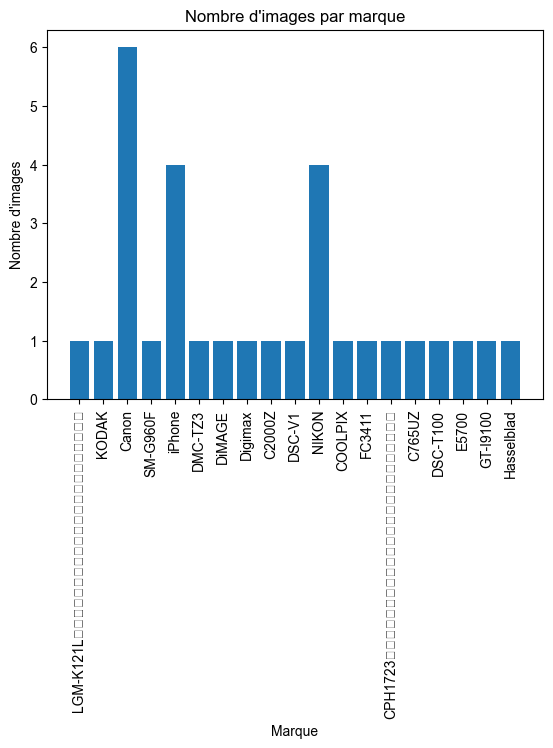

In [91]:
marques = {}

for modele in nb_images_camera:
    marque = modele.split(' ')[0].encode('utf-8', 'ignore').decode('utf-8') # Encode la chaîne de caractères en utilisant l'encodage UTF-8 et en ignorant les caractères invalides
    if marque in marques:
        marques[marque].append(modele)
    else:
        marques[marque] = [modele]

print(marques)

entity4 = list(marques.keys())
print([len(el) for el in marques.values()])
val4 = [len(el) for el in marques.values()]
plt.bar(entity4, val4)
plt.title("Nombre d'images par marque")
plt.xlabel("Marque")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90) # Fait pivoter les étiquettes x de 45 degrés pour améliorer la lisibilité
plt.show()


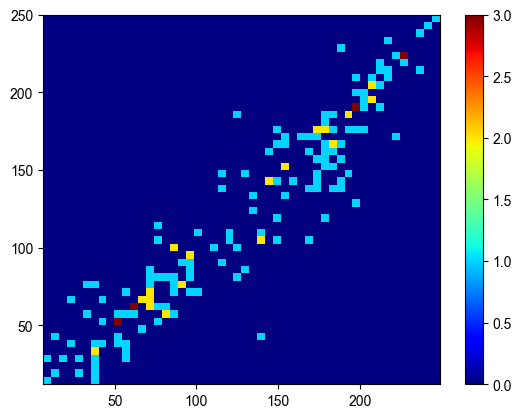

In [95]:
# Initialiser un tableau vide pour stocker toutes les couleurs
all_colors = []

# Parcourir toutes les images et ajouter leurs couleurs à la liste de toutes les couleurs
for image in data:
    if 'colors' in data[image]:
        colors = data[image]['colors']
        all_colors += colors

# Convertir la liste de couleurs en un tableau NumPy
all_colors = np.array(all_colors)

# Créer l'histogramme en utilisant Matplotlib
plt.hist2d(all_colors[:, 0], all_colors[:, 1], bins=50, cmap=plt.cm.jet)
plt.colorbar()

# Afficher l'histogramme
plt.show()